In [1]:
from ipynb.fs.defs.Preprocessing_Module import read_data, add_topological, add_landcover, merge_new_data, fill_data, select_columns, reshape_dataset, fillna_dataset, remove_nan_features, unused_stations
from ipynb.fs.defs.Feature_Expansion_Module import feature_expansion
from ipynb.fs.defs.Initializer_Module import initializer
from ipynb.fs.defs.XGboost_Model_Module import Xgboost_model
# from ipynb.fs.defs.Neural_Network_Module import FeedforwardNeuralNetModel
# from ipynb.fs.defs.Model_Validation_Module import give_predictions_nn, evaluate_nn, give_predictions_xgboost, evaluate_xgboost, validate_results, merge_predictions
from ipynb.fs.defs.Model_Validation_Module import give_predictions_xgboost, evaluate_xgboost, validate_results, merge_predictions
import numpy as np
import pandas as pd

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [3]:
data = read_data('../Datasets/Africa/Ivory Coast/IC_aedes_aegypti.csv')
data = merge_new_data('../Datasets/Africa/Ivory Coast/monthly_data/IC_env_2024_10_2km_processed.csv', data)
columns = ['dt_placement', 'x', 'y', 'total', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/africa_ivory_coast_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/africa_ivory_coast_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['dt_placement', 'week', 'month', 'year', 'method', 'site', 'x', 'y',
       'altitude', 'genus', 'total', 'methods', 'sampling point', 'ecozone',
       'aedesspecies', 'aedesfemale', 'aedesmale', 'station_id',
       'dt_placement_original', 'region', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7',
       'dt_placement_minus_14', 'dt_placement_minus_7_avail',
       'dt_placement_minus_14_avail', 'acc_rainfall_1week',
      

In [4]:
# set the date of prediction for the test set
date = '2024-10-01'

# set the filename for export
case = 'Aedes_Africa_IC_'

# set the filename to export
path = './predictions/Ivory_Coast/'

title = date[:-3].replace('-','_')
title = case + title

# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'class_regression'

In [5]:
data = feature_expansion(data)

In [6]:
data = initializer(data, model_type, [-1,   1., 2.,  3., 5., 8.,  11., 14., 23., 40., np.inf])

Bounds: [-1.  1.  2.  3.  5.  8. 11. 14. 23. 40. inf]


In [7]:
print("#===========================================")
print("Performance of the previous month")
print("#===========================================")
print()
validate_results(path+case + date[:-3].replace(date[:-3].split('-')[1],str(int(date[:-3].split('-')[1])-1)).replace('-','_')+'.csv',data)

#===========================================
Performance of the previous month
#===========================================

No predictions with difference less than 8 days


In [8]:
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================

# Spit to train and test based on date of predictions
test = data.loc[data[date_col] >= pd.to_datetime(date)]
data = data.loc[data[date_col] < pd.to_datetime(date)]

# Delete from test set stations that are not used during the last 3 years
# test = unused_stations(data, test, period=3)

#Remove features that are more 40% filled with nan values in the test set
data, test = remove_nan_features(data, test, 0.4)

# set the only_env as True if there are no mosquitoes for the forecast month
only_env=None    
if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
    only_env=False
elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
    only_env=True
else:
    print('No data left for prediction')
    
num_class = 1
hidden_layers = [264,128,128,64,32]
learning_rate = 0.001
epochs = 50
batch_size = 128
dropout = 0.2
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = ['scaling']
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance (!very time consuming!)
fi = False

print(only_env)
    
if only_env != None:
    # Run first without entomological features
    print("#===========================================")
    print("Predictions without entomological features")
    print("#===========================================")
    print()
    data_env = data.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)

    data_env = data_env.dropna().reset_index(drop=True)
    test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)

    
    model = FeedforwardNeuralNetModel(num_features=len(data_env.iloc[0,:])-2, num_class=num_class,
                                      hidden_layers = hidden_layers, model_type=model_type,
                                      learning_rate = learning_rate, epochs = epochs, batch_size = batch_size,
                                      dropout = dropout, embedding_data=embedded_data, 
                                      transformation_list=transformation_list, early_stop = early_stop, 
                                      l1_weight=0, l2_weight=0, weights=False)

    evaluate_nn(model, data_env, fi = fi)

    predictions_env = give_predictions_nn(model, data_env, test_env, env = True, filepath = path, case = title,
                                          export = only_env)

    # Run with entomological features if at least one station has mosquitos number
    if not only_env:
        print("#===========================================")
        print("Predictions with entomological features")
        print("#===========================================")
        print()
        
        data_entom = data.dropna().reset_index(drop=True)
        test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        model = FeedforwardNeuralNetModel(num_features=len(data_entom.iloc[0,:])-2, num_class=num_class,
                                          hidden_layers = hidden_layers, model_type=model_type,
                                          learning_rate = learning_rate, epochs = epochs, batch_size = batch_size,
                                          dropout = dropout, embedding_data=embedded_data, 
                                          transformation_list=transformation_list, early_stop = early_stop, 
                                          l1_weight=0, l2_weight=0, weights=False)
        
        evaluate_nn(model, data_entom, fi = fi)

        predictions_entom = give_predictions_nn(model, data_entom, test_entom, env = False, filepath = path,
                                                case = title, export = False)

        print("#===========================================")
        print("Predictions with/without entomological features")
        print("#===========================================")
        merge_predictions(predictions_env,predictions_entom,path,title,export=True)

Features Dropped: ['ndvi', 'ndwi', 'ndmi', 'ndbi', 'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean', 'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean', 'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean', 'lst']
True
#===========================================
Predictions without entomological features
#===========================================



NameError: name 'FeedforwardNeuralNetModel' is not defined

Features Dropped: ['ndvi', 'ndwi', 'ndmi', 'ndbi', 'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean', 'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night', 'lst_apr_day_mean', 'lst']
#===========================================
Predictions without entomological features
#===========================================



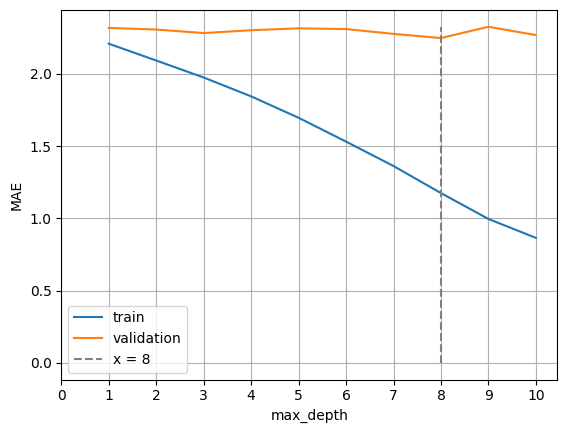

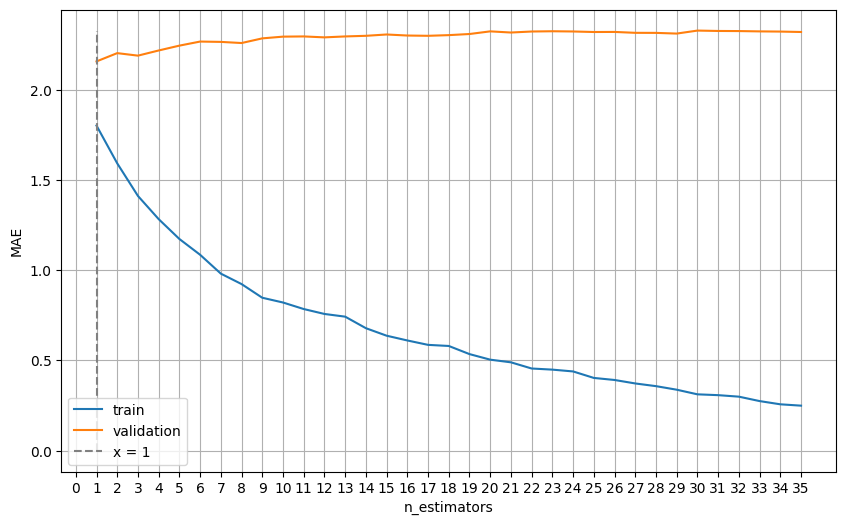

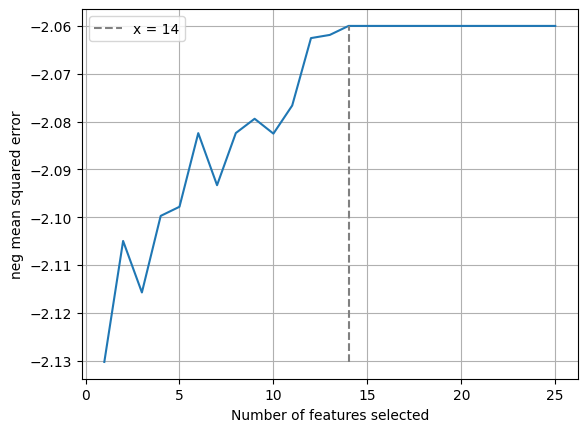

max_depth:  8
Number of estimators:  1
Selected_features:  Index(['x', 'y', 'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean',
       'lst_feb_night_mean', 'lst_apr_night_mean', 'ASPECT_mean_200m',
       'HILLSHADE_mean_1km', 'null_island_distance', 'days_distance', 'mo_cos',
       'year', 'summer_days_month'],
      dtype='object')
MAE on train set:  1.8146002317497103
min prediction: 0.0
max prediction: 3.0

MAE on test set:  1.8333333333333333
Error <= 3: 82.41 %
min prediction: 0.0
max prediction: 3.0


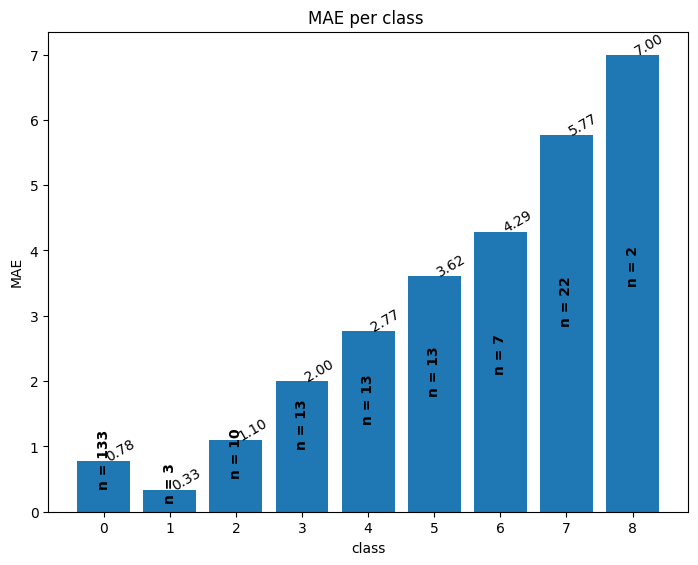

-----------|class error-MAE| difference-----------
mean: 3.9268505373768527
std: 2.1696315113310485
coefficient of variation (std/mean): 0.5525118643248308

----------normalized difference-------------
mean: 0.5890275806065279
std: 0.32544472669965724


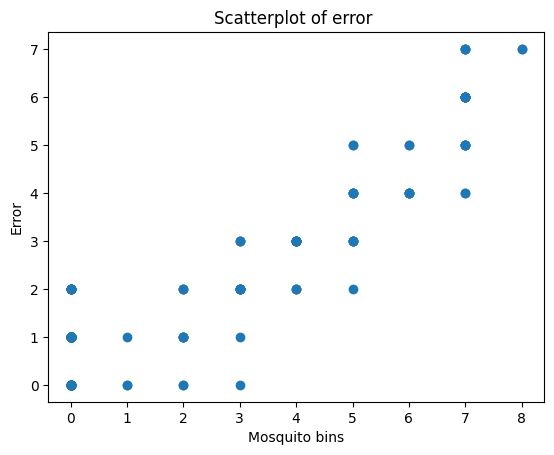

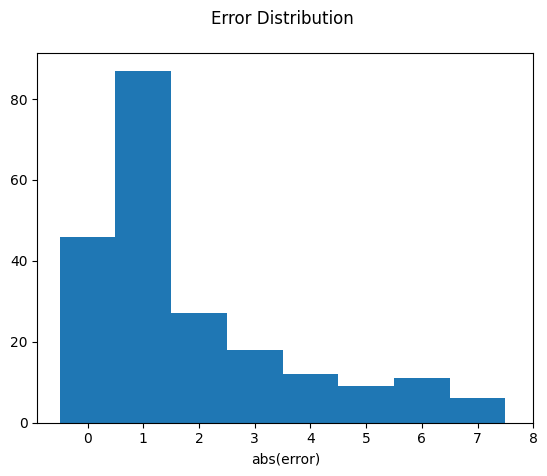

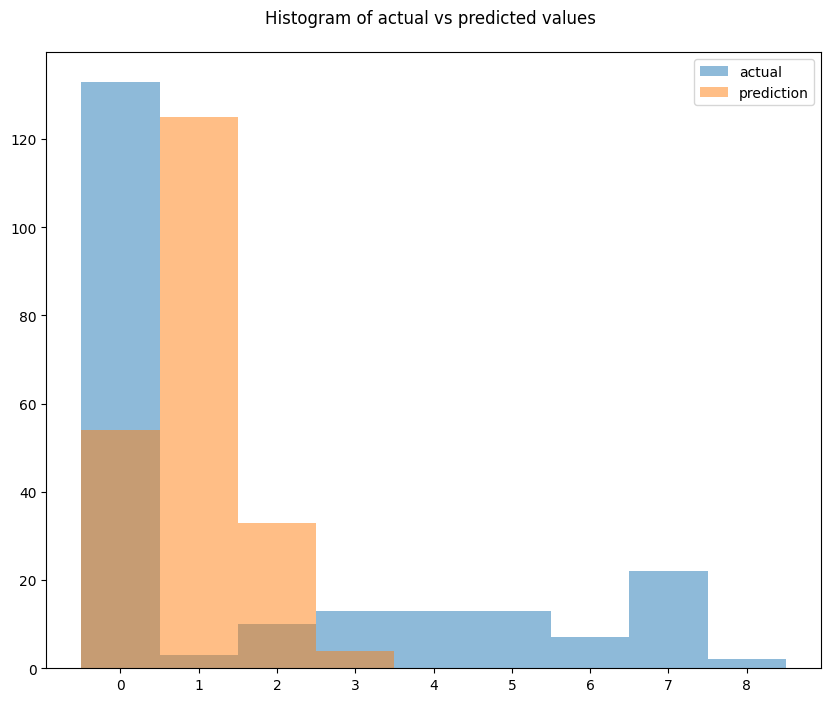

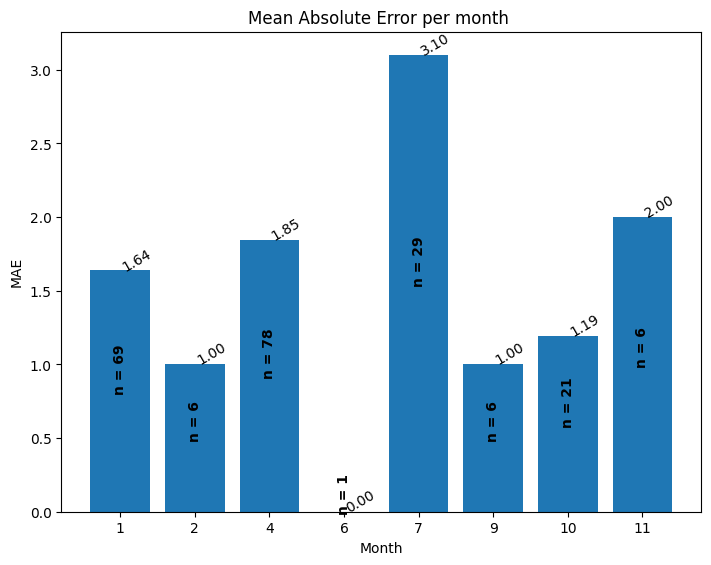

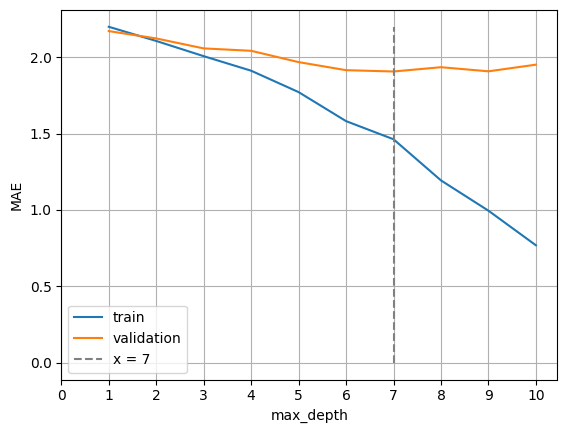

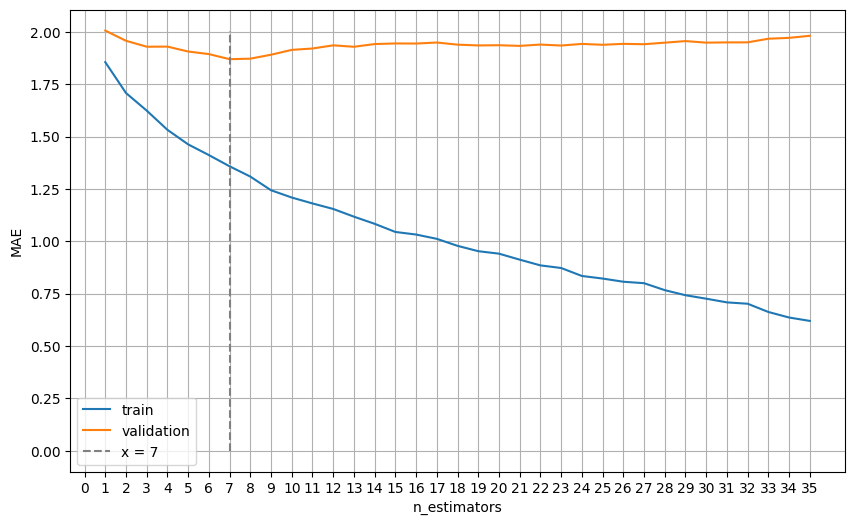

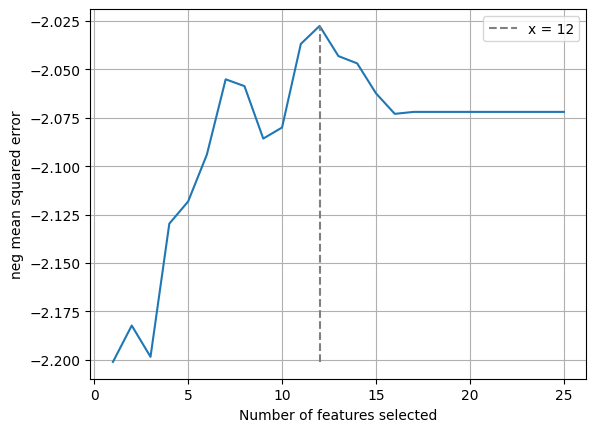

max_depth:  7
Number of estimators:  7
Selected_features:  Index(['x', 'y', 'lst_mar_day_mean', 'lst_jan_night_mean',
       'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean',
       'ASPECT_mean_200m', 'null_island_distance', 'days_distance', 'mo_cos',
       'summer_days_month'],
      dtype='object')
prediction
0.0     35
1.0     85
2.0     60
3.0     67
4.0    141
5.0     83
Name: count, dtype: int64

Low risk category stations: 120
Medium risk category stations: 351
High risk category stations: 0


In [8]:
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================

data = data.drop(columns = ['acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan'])

# Spit to train and test based on date of predictions
test = data.loc[data[date_col] >= pd.to_datetime(date)]
data = data.loc[data[date_col] < pd.to_datetime(date)]

# Delete from test set stations that are not used during the last 3 years
# test = unused_stations(data, test, period=3)

#Remove features that are more 40% filled with nan values in the test set
data, test = remove_nan_features(data, test, 0.3)

# set the only_env as True if there are no mosquitoes for the forecast month
only_env=None    
if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
    only_env=False
elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
    only_env=True
else:
    print('No data left for prediction')
    

learning_rate = 0.3
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = []
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance (!very time consuming!)
fi = False
    
if only_env != None:
    # Run first without entomological features
    print("#===========================================")
    print("Predictions without entomological features")
    print("#===========================================")
    print()
    data_env = data.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    
    data_env = data_env.dropna().reset_index(drop=True)
    test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)

    model = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                          embedding_data = embedded_data,  transformation_list = transformation_list,
                          early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)
    
    evaluate_xgboost(model, data_env, fi = fi)

    predictions_env = give_predictions_xgboost(model, data_env, test_env, env = True, filepath = path, case = title,
                                               fi = fi, export = only_env)


    # Run with entomological features if at least one station has mosquitos number
    if not only_env:
        print("#===========================================")
        print("Predictions with entomological features")
        print("#===========================================")
        print()
        
        data_entom = data.dropna().reset_index(drop=True)
        test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        model = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                              embedding_data = embedded_data,  transformation_list = transformation_list,
                              early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)
    
        evaluate_xgboost(model, data_entom, fi = fi)

        predictions_entom = give_predictions_xgboost(model, data_entom, test_entom, env = True, filepath = path,
                                                     fi = fi, case = title, export = only_env)

        print("#===========================================")
        print("Predictions with/without entomological features")
        print("#===========================================")
        merge_predictions(predictions_env,predictions_entom, path, title, export=True)